In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import sys
import os

sys.path.append(os.path.abspath('..'))
from core.DICT import *

#detections data
radar_detections = pd.read_csv('../../data/cleaned_data/preprocessed_radar_detections.csv')
tagged_detections = pd.read_csv('../../data/raw_data/detections_tagged.csv')

#label data
labels = pd.read_csv('../../data/labels/full_non_transit_stopped_radar_labels.csv')

In [3]:
# merge data

full_detections = pd.concat([radar_detections, tagged_detections])

full_detections = full_detections.merge(labels, on='id_track', how='right')

print(f'Total number of detections: {len(full_detections)}')
print(f'Total number of unique tracks: {full_detections["id_track"].nunique()}')

Total number of detections: 1237040
Total number of unique tracks: 1880


In [5]:
labelled_detections = full_detections[full_detections['type_m2_agg'].notna()]
print(f'Total number of unique labelled tracks: {labelled_detections["id_track"].nunique()}')

Total number of unique labelled tracks: 1689


In [7]:
from core.sum_stats import SumStatsBaseline

summary_df = SumStatsBaseline(labelled_detections)()
summary_df = summary_df.merge(labels[['id_track', 'type_m2_agg']], on='id_track', how='left', validate='one_to_one')

In [8]:
feature_subset = SumStatsBaseline.FEATURE_NAMES

In [10]:
#Build XGBoost Model


import xgboost as xgb
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import joblib
import json
import numpy as np

# Prepare features and target
X = summary_df[feature_subset]
y = summary_df['type_m2_agg']

# Map labels to numeric
y_numeric = y.map(TYPE2NUM)

# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42
)

# Define base model
base_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    random_state=42
)

# Hyperparameter grid
param_grid = {
    'max_depth': [16],
    'learning_rate': [0.1],
    'n_estimators': [300],    
    'reg_alpha': [0.01],
    'reg_lambda': [5]
}

# Manual grid search with cross-validation
best_score = -np.inf
best_params = None
results = []

for params in tqdm(list(ParameterGrid(param_grid)), desc="Grid search progress"):
    model = base_model.set_params(**params)
    scores = cross_val_score(model, X_train, y_train, cv=4, scoring='accuracy', n_jobs=-1)
    mean_score = np.mean(scores)
    results.append((params, mean_score))

    if mean_score > best_score:
        best_score = mean_score
        best_params = params

# Train best model on full training set
best_model = base_model.set_params(**best_params)
best_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# Print results
print("Best params:", best_params)
print("Best CV accuracy: {:.4f}".format(best_score))
print("Test Set Accuracy: {:.4f}".format(test_accuracy))

Grid search progress: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Best params: {'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 300, 'reg_alpha': 0.01, 'reg_lambda': 5}
Best CV accuracy: 0.6099
Test Set Accuracy: 0.5976


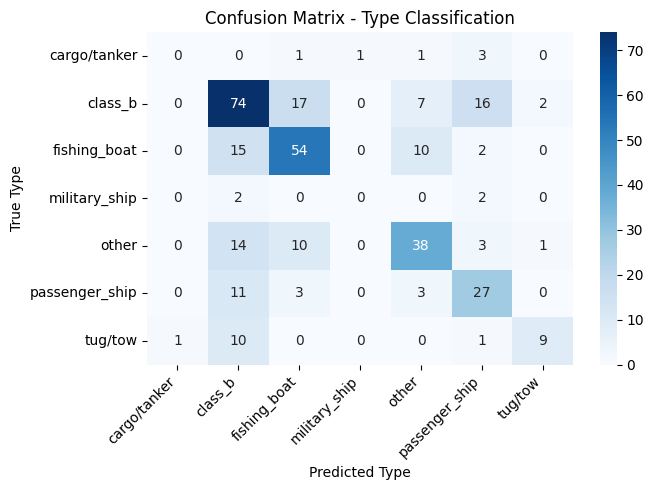

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Convert numeric to string labels just once

y_test_str = y_test.map(NUM2TYPE)
y_pred_str = pd.Series(y_pred).map(NUM2TYPE)

# Create confusion matrix with string labels
labels_order = sorted(set(y_test_str) | set(y_pred_str))  # all unique class labels in order
cm = confusion_matrix(y_test_str, y_pred_str, labels=labels_order)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, 
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)

plt.title('Confusion Matrix - Type Classification')
plt.xlabel('Predicted Type')
plt.ylabel('True Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()




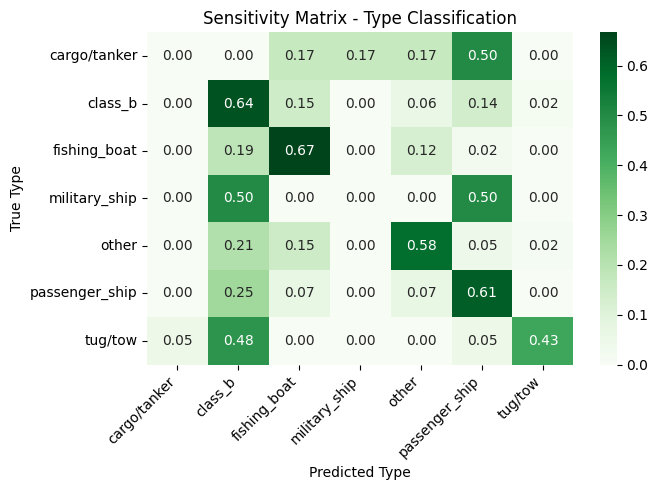

In [12]:
# Compute sensitivity matrix (recall per class)
sensitivity_matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot sensitivity matrix
plt.figure(figsize=(7, 5))
sns.heatmap(sensitivity_matrix, 
            annot=True,
            fmt='.2f',
            cmap='Greens',
            xticklabels=labels_order,
            yticklabels=labels_order)

plt.title('Sensitivity Matrix - Type Classification')
plt.xlabel('Predicted Type')
plt.ylabel('True Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
